# Saving and loading

We often want to save the parameters of a trained model, so that we can use it again later without needing to re-train. 

All Feedbax components—including, automatically and for free, any that you might write—are [PyTrees](feedbax/examples/pytrees): they are represented as tree-structured data. Equinox is able to [save](https://docs.kidger.site/equinox/examples/serialisation/) this data to a file. 

Feedbax provides some functions to make this slightly easier. However, you can also [learn](https://docs.kidger.site/equinox/api/serialisation/) to use the Equinox functions `tree_serialise_leaves` and `tree_deserialize_leaves`, if you prefer a different scheme for saving and loading.

Here's an example of how to use the functions provided by Feedbax. 

We'll start by writing a function that sets up the components we're going to want to save,

In [2]:
import jax

from feedbax.task import SimpleReaches

from feedbax.xabdeef.losses import simple_reach_loss
from feedbax.xabdeef.models import point_mass_nn

# The leading asterisk forces all the arguments to be passed as keyword arguments
def setup(*, workspace, n_steps, dt, hidden_size, key):

    task = SimpleReaches(
        loss_func=simple_reach_loss(), 
        workspace=workspace, 
        n_steps=n_steps
    )

    model = point_mass_nn(task, dt=dt, hidden_size=hidden_size, key=key)
    
    return task, model 

then use this function to get a task and model. We'll also want to save the parameters we use to set up the task and model, so let's store them together in a dictionary called `hyperparameters`.

In [3]:
hyperparameters = dict(
    workspace=((-1., -1.),  # Workspace bounds ((x_min, y_min), (x_max, y_max)
               (1., 1.)),
    n_steps=100,  # Number of time steps per trial
    dt=0.05,  # Duration of a time step
    hidden_size=50,  # Number of units in the hidden layer of the controller
)

key_init, key_train, key_eval = jax.random.split(jax.random.PRNGKey(0), 3)

task, model = setup(**hyperparameters, key=key_init)

Now train the model to perform the task. We just do a short training run, since in this case we're interested in saving the model rather than whether it has converged on a solution or not.

In [4]:
import optax

from feedbax.trainer import TaskTrainer


trainer = TaskTrainer(
    optimizer=optax.adam(learning_rate=1e-2)
)

model_trained, _ = trainer(
    task=task, 
    model=model, 
    n_batches=1000, 
    batch_size=250, 
    where_train=lambda model: model.step.net,
    key=key_train,
)

compile:   0%|          | 0/1 [00:00<?, ?it/s]

Training step compiled.
Validation step compiled.


train batch:   0%|          | 0/1000 [00:00<?, ?it/s]


Training iteration: 0
	training loss: 3.94e+01
	validation loss: 5.14e+00

Training iteration: 100
	training loss: 2.86e-02
	validation loss: 5.32e-03

Training iteration: 200
	training loss: 8.28e-03
	validation loss: 1.58e-03

Training iteration: 300
	training loss: 6.48e-03
	validation loss: 1.25e-03

Training iteration: 400
	training loss: 5.37e-03
	validation loss: 1.06e-03

Training iteration: 500
	training loss: 4.46e-03
	validation loss: 9.42e-04

Training iteration: 600
	training loss: 3.98e-03
	validation loss: 8.68e-04

Training iteration: 700
	training loss: 3.58e-03
	validation loss: 8.12e-04

Training iteration: 800
	training loss: 3.34e-03
	validation loss: 7.66e-04

Training iteration: 900
	training loss: 2.94e-03
	validation loss: 7.34e-04

Training iteration: 999
	training loss: 3.03e-03
	validation loss: 7.11e-04


Completed training run on a total of250,000 trials.


Now let's save our task and trained model to a file, then immediately load it again.

In [7]:
from feedbax import save, load

save_path = "example_save.eqx"  

save(
    save_path,
    (task, model_trained),
    hyperparameters=hyperparameters, 
)

In [8]:
task_loaded, model_loaded = load(save_path, setup)

How does this work, and why do we pass `setup` to `load`?

The short explanation is that the shape of the data we pass to `save`---in this case a tuple `(task, model)`---has to match the shape of the data returned by the `setup` function which we'll pass to `load`. Also, we can pass hyperparameters to `save` that will be used by `load` to call `setup` properly.

!!! Note    
   Python includes the module [`pickle`](https://docs.python.org/3/library/pickle.html), which can save and load entire Python objects without needing to specify, at the time of loading, how those objects were created---that is, no function like `setup` needs to be retained between save time and load time. This seems convenient, but it is not good practice in general:
   
   - Upon loading, Python will automatically execute code found in a pickle file, in order to reconstruct the pickled objects. This is a security issue. If someone shares a pickled model with you, they (or an interloper) could insert harmful code into the pickle file, and you may not know it's there until you run it.
   - You probably still have to keep track of how the objects in the pickle were created, for your research to be reproducible in detail. It is better to do this explicitly.
   - Some of the components we use, such as `lambda` expressions, are not compatible with `pickle`.
   
   See the Equinox [documentation](https://docs.kidger.site/equinox/examples/serialisation/) for a similar discussion of these limitations.

The longer explanation:

- We wrote `setup` as a reproducible way to (re)build our model and task.
- All the arguments we passed to `setup` to construct our specific model and task are bundled together in `hyperparameters`.
- We passed `(task, model_trained)` to `save` because this matches the return value of our setup function: `task, model = setup(...)`.
- `save` also puts any `hyperparameters` in the same file.
- `load`:
    1. loads `hyperparameters` from the file
    2. generates a skeleton `(task, model)` by passing `hyperparameters` to `setup`, along with a dummy key---the key doesn't matter, since we'll soon be overwriting with the reloaded data
    3. fills the skeleton by loading the data that `save` had saved to the file, from `(task, model_trained)`
    4. returns `task, model`, which in this case we assign to `task_loaded, model_loaded` so we can distinguish them from the task and model
    
In summary: `load` expects that the file it loads will contain data that matches the kind of PyTree generated by `setup`. That will be true, if when we call `save`, we pass it a PyTree that matches the return value of `setup`. In this case, that PyTree has a structure that looks like `(task, model)`---whose type is `tuple[AbstractTask, AbstractModel]`.

In general, `save` and `load` can be used to save the contents of *any* PyTree, so long as it's the same kind of PyTree returned by the setup function. For example, maybe we want to store just the model, and don't care about storing the task. We could easily have done something like

```python
def setup(*, .., key):
    model = ..
    return model

model = setup(**hyperparameters, key=key_init)
    
# Train the model 
# ...

save(
    save_path, 
    model,
    hyperparameters=hyperparameters,
)
    
model = load(save_path, setup)
```

Or, we could achieve the same thing by wrapping our existing setup function to make sure that its return value is the same kind of PyTree as what we passed to `save`.

In [9]:
save_path_model_only = "example_save_model_only.eqx"  

save(
    save_path_model_only,
    model_trained,
    hyperparameters=hyperparameters, 
)

def setup_model_only(**kwargs):
    _, model = setup(**kwargs)
    return model

model_loaded = load(
    save_path_model_only, 
    setup_model_only,
)

Finally, we can compare the trained model with itself after reloading, to show that the process of saving to a file preserves the model.

First, the original.

(<Figure size 1200x600 with 3 Axes>,
 array([<Axes: title={'center': 'Position'}, xlabel='$x$', ylabel='$y$'>,
        <Axes: title={'center': 'Velocity'}, xlabel='$\\dot x$', ylabel='$\\dot y$'>,
        <Axes: title={'center': 'Control force'}, xlabel='$\\mathrm{f}_x$', ylabel='$\\mathrm{f}_y$'>],
       dtype=object))

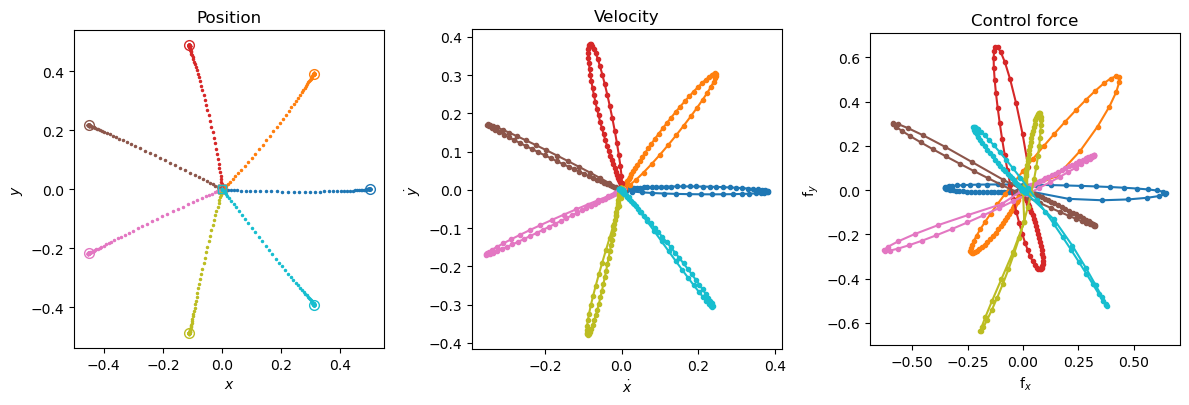

In [12]:
from feedbax.plot import plot_reach_trajectories

states = task.eval(model_trained, key=key_eval)

plot_reach_trajectories(
    states,
    trial_specs = task.validation_trials,
)

Then the reloaded copy:

(<Figure size 1200x600 with 3 Axes>,
 array([<Axes: title={'center': 'Position'}, xlabel='$x$', ylabel='$y$'>,
        <Axes: title={'center': 'Velocity'}, xlabel='$\\dot x$', ylabel='$\\dot y$'>,
        <Axes: title={'center': 'Control force'}, xlabel='$\\mathrm{f}_x$', ylabel='$\\mathrm{f}_y$'>],
       dtype=object))

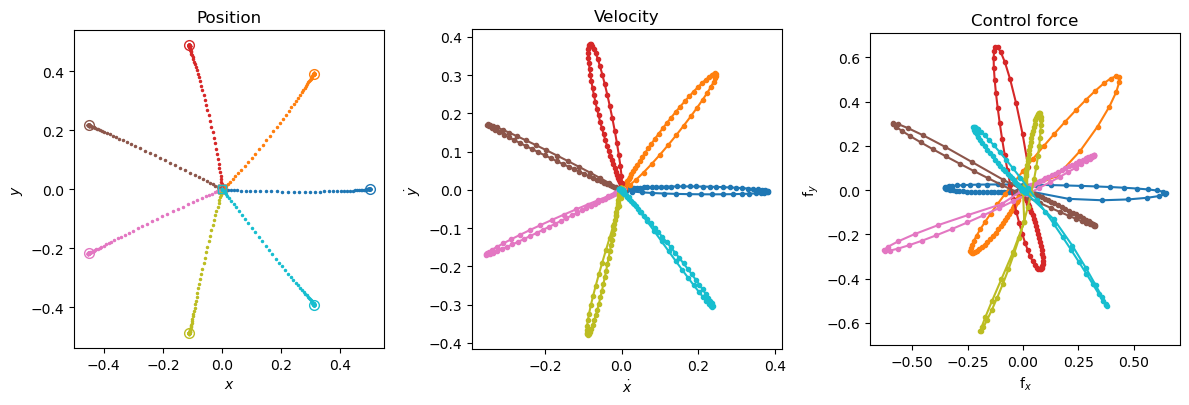

In [13]:
states = task_loaded.eval(model_loaded, key=key_eval)

plot_reach_trajectories(
    states,
    trial_specs = task.validation_trials,
)